In [1]:
import torch
from torch import autograd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets


In [2]:
in_height = 120
in_width = 120
in_channels = 3

In [3]:
##Divide ConvNet into multiple parts 
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [4]:
## conv layer (stem layer)
class _Stem(nn.Module): 
    def __init__(self):
        super(_Stem, self).__init__()
        self.stem = nn.Sequential(
                        BasicConv2d(in_channels, 64, kernel_size=7, padding=2, stride=2),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                        BasicConv2d(64, 64, kernel_size=1),
                        BasicConv2d(64, 192, kernel_size=3, padding=1),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                    )

    def forward(self, x):
        x = self.stem(x)

        return x


In [5]:
## auxiliary layer for vanishing gradient
class _Auxiliary_Classifiers(nn.Module):
    def __init__(self, num_fts):
        super(_Auxiliary_Classifiers, self).__init__()
        self.aux_classifier = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=5, stride=3, padding=2),
                                    BasicConv2d(num_fts, 128, kernel_size=1),
                                )

        self.classifier = nn.Sequential(
                                nn.Linear(5 * 5 * 128, 1024),
                                nn.Dropout(p=0.7),
                                nn.Linear(1024, 5)
                            )

    def forward(self, x):
        x = self.aux_classifier(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [6]:
class _Inception_Module(nn.Module):
    def __init__(self, conv1x1, conv1x1_reduce_3, conv1x1_reduce_5,
                        conv3x3, conv5x5, conv1x1_reduce_pool,
                        num_fts):
        super(_Inception_Module, self).__init__()

        self.conv1x1_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1, kernel_size=1),
                                )

        self.conv3x3_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1_reduce_3, kernel_size=1),
                                    BasicConv2d(conv1x1_reduce_3, conv3x3, kernel_size=3, padding=1),
                                )

        self.conv5x5_branch = nn.Sequential(
                                    BasicConv2d(num_fts, conv1x1_reduce_5, kernel_size=1),
                                    BasicConv2d(conv1x1_reduce_5, conv5x5, kernel_size=5, padding=2),
                                )

        self.pool_branch = nn.Sequential(
                                    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                    BasicConv2d(num_fts, conv1x1_reduce_pool, kernel_size=1),
                                )

    def forward(self, x):
        x1x1 = self.conv1x1_branch(x)
        x3x3 = self.conv3x3_branch(x)
        x5x5 = self.conv5x5_branch(x)
        xpool = self.pool_branch(x)

        x = torch.cat([x1x1, x3x3, x5x5, xpool], 1)

        return x 

In [7]:
class GoogleLeNet(nn.Module):
    def __init__(self):
        super(GoogleLeNet, self).__init__()
        self.features1 = nn.Sequential(
                            _Stem(),
                            _Inception_Module(conv1x1=64, conv1x1_reduce_3=96, conv3x3=128, 
                                conv1x1_reduce_5=16, conv5x5=32, conv1x1_reduce_pool=32, 
                                num_fts=192),
                            _Inception_Module(conv1x1=128, conv1x1_reduce_3=128, conv3x3=192, 
                                conv1x1_reduce_5=32, conv5x5=96, conv1x1_reduce_pool=64, 
                                num_fts=256),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                            _Inception_Module(conv1x1=192, conv1x1_reduce_3=96, conv3x3=208, 
                                conv1x1_reduce_5=16, conv5x5=48, conv1x1_reduce_pool=64, 
                                num_fts=480)
                        )

        self.features2 = nn.Sequential(
                            _Inception_Module(conv1x1=160, conv1x1_reduce_3=112, conv3x3=224, 
                                conv1x1_reduce_5=24, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512),
                            _Inception_Module(conv1x1=128, conv1x1_reduce_3=128, conv3x3=256, 
                                conv1x1_reduce_5=24, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512),
                            _Inception_Module(conv1x1=112, conv1x1_reduce_3=144, conv3x3=288, 
                                conv1x1_reduce_5=32, conv5x5=64, conv1x1_reduce_pool=64, 
                                num_fts=512)
                        )

        self.features3 = nn.Sequential(
                            _Inception_Module(conv1x1=256, conv1x1_reduce_3=160, conv3x3=320, 
                                conv1x1_reduce_5=32, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=528),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                            _Inception_Module(conv1x1=256, conv1x1_reduce_3=160, conv3x3=320, 
                                conv1x1_reduce_5=32, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=832),
                            _Inception_Module(conv1x1=384, conv1x1_reduce_3=192, conv3x3=384, 
                                conv1x1_reduce_5=48, conv5x5=128, conv1x1_reduce_pool=128, 
                                num_fts=832)
                        )
        
        self.Aux1 = _Auxiliary_Classifiers(num_fts=512)
        self.Aux2 = _Auxiliary_Classifiers(num_fts=528)

        self.fc = nn.Linear(1024, 5)
    def forward(self, x):
        x = self.features1(x)

        if self.training:
            aux1 = self.Aux1(x)

        x = self.features2(x)

        if self.training:
            aux2 = self.Aux2(x)

        x = self.features3(x)
        x = F.avg_pool2d(x, kernel_size=7)
        x = x.view(-1 ,1024)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.fc(x)
        
        if self.training:
            return x, aux1, aux2
        else:
            return x

In [57]:
def train(model, criterion, optimizer, lr_scheduler, dsets_loader, dset_sizes, lr = 0.001, num_epochs = 20):
    since = time.time()
    use_model = model
    best_acc = 0.0
    #accuracy = []
    #epoch_num = []
    #loss_arr = []
    history = {
        x :[]
        for x in ['train','val']
    }
    
    for i in range(num_epochs):
        print('Epoch {}/{}'.format(i, num_epochs - 1))
        print('-'*10)
        for mode in ['train','val']:
            start = time.time()
            
            if mode == 'train':
                optimizer = lr_scheduler(optimizer, i, init_lr = lr)
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dsets_loader[mode]:
                
                inputs, labels = data
                #print(inputs)
                inputs_, labels_ = Variable(inputs.cuda()), Variable(labels.cuda())
                
                optimizer.zero_grad()
                
                
                
                if mode == 'train':
                    o1, o2, o3 = model(inputs_)
                    _, preds = torch.max(o1.data, 1)
                
                    loss1 = criterion(o1, labels_)
                    loss2 = criterion(o2, labels_)
                    loss3 = criterion(o3, labels_)

                    loss = loss1 + 0.3 * (loss2 + loss3)
                   
                else:
                    outputs = model(inputs_)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels_)
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels_.data)
                
            epoch_loss = running_loss / dset_sizes[mode]
            #loss_arr.append(epoch_loss)
            epoch_acc = running_corrects / dset_sizes[mode]
            #accuracy.append(epoch_acc)
            epoch_time = time.time() - start
            
            history_dict =  {
                'mode':mode,
                'epoch':i,
                'epoch_loss': epoch_loss,
                'epoch_accuracy': epoch_acc,
                'learing_rate':optimizer.state_dict()['param_groups'][0]['lr']
                
            }
            
            history[mode].append(history_dict)
            
            print('{} Loss: {:.4f} Acc:{:.4f} Time: {:.0f}m {:.0f}s'.format(mode, epoch_loss, epoch_acc, epoch_time//60, epoch_time%60))
            
            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
    time_elapsed = time.time() - since
    
    print('Training completion in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best validation accuracy is {:.4f}'.format(best_acc))
    
    print('save mode')
    ##here I want to save the history of the process in order to debug
    with open('history.pickle','wb') as f:
        pickle.dump(history, f)
    
    return best_model, best_acc, history

In [58]:
#add scheduler to better control learning rate 
def exp_lr_scheduler(optimizer, epoch, init_lr = 0.001, lr_decay_epoch = 5):
    lr = init_lr * (0.9 ** (epoch // lr_decay_epoch))
    
    if epoch % lr_decay_epoch == 0:
        print('Learning rate is changed to {}'.format(lr))
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [59]:
net = GoogleLeNet().cuda()

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay = 0.0005)
lr_scheduler = exp_lr_scheduler
lr = 0.001

In [61]:
def load_data(train_path, val_path=None):
    if val_path is None:
        val_path = train_path
    train_transfrom = transforms.Compose([
        
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])

    val_transfrom = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
                ])
    dsets = {
        'train': datasets.ImageFolder(train_path, train_transfrom),
        'val': datasets.ImageFolder(val_path, val_transfrom)
    }
    dset_loaders = {
        x: torch.utils.data.DataLoader(dsets[x], batch_size=7, shuffle=True, num_workers=4)
        for x in ['train', 'val']
    }
    dset_sizes = {
        x: len(dsets[x])
        for x in ['train', 'val']
    }
    
    dset_classes = dsets['train'].classes
    return dset_loaders, dset_sizes, dset_classes
        

    


In [62]:
train_file = './alzheimers'
val_file = ''
##load data
#dset_loaders, dset_sizes, dset_classes = mri_loader.load_data(train_path=train_path, val_path=val_path)

In [63]:
dset_loaders, dset_sizes, dset_classes = load_data(train_path=train_file)

print(dset_sizes)
print(dset_classes)
print(dset_loaders)

{'train': 68, 'val': 68}
['label_0', 'label_1', 'label_2']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fd5d181e320>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fd5d17acfd0>}


In [64]:
best_model, best_acc, history = train(net, criterion, optimizer, lr_scheduler,
dset_loaders, dset_sizes, lr, 50)

Epoch 0/49
----------
Learning rate is changed to 0.001
train Loss: 0.2035 Acc:0.6471 Time: 0m 1s
val Loss: 0.2373 Acc:0.5882 Time: 0m 0s

Epoch 1/49
----------
train Loss: 0.1049 Acc:0.7941 Time: 0m 1s
val Loss: 0.7673 Acc:0.5882 Time: 0m 0s

Epoch 2/49
----------
train Loss: 0.1062 Acc:0.7794 Time: 0m 1s
val Loss: 0.7671 Acc:0.5882 Time: 0m 0s

Epoch 3/49
----------
train Loss: 0.0854 Acc:0.8235 Time: 0m 1s
val Loss: 0.1664 Acc:0.6912 Time: 0m 0s

Epoch 4/49
----------
train Loss: 0.0911 Acc:0.8382 Time: 0m 1s
val Loss: 0.0626 Acc:0.8235 Time: 0m 0s

Epoch 5/49
----------
Learning rate is changed to 0.0009000000000000001
train Loss: 0.0731 Acc:0.8824 Time: 0m 1s
val Loss: 0.0422 Acc:0.8529 Time: 0m 0s

Epoch 6/49
----------
train Loss: 0.0709 Acc:0.8382 Time: 0m 1s
val Loss: 0.0718 Acc:0.8235 Time: 0m 0s

Epoch 7/49
----------
train Loss: 0.0841 Acc:0.8235 Time: 0m 1s
val Loss: 0.0514 Acc:0.8382 Time: 0m 0s

Epoch 8/49
----------
train Loss: 0.0769 Acc:0.7941 Time: 0m 1s
val Loss: 0.

In [65]:
print(history)

{'train': [{'mode': 'train', 'epoch': 0, 'epoch_loss': 0.2035350922275992, 'epoch_accuracy': 0.6470588235294118, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 1, 'epoch_loss': 0.10487604579504799, 'epoch_accuracy': 0.7941176470588235, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 2, 'epoch_loss': 0.10616400487282697, 'epoch_accuracy': 0.7794117647058824, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 3, 'epoch_loss': 0.0854384550715194, 'epoch_accuracy': 0.8235294117647058, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 4, 'epoch_loss': 0.09111955498947817, 'epoch_accuracy': 0.8382352941176471, 'learing_rate': 0.001}, {'mode': 'train', 'epoch': 5, 'epoch_loss': 0.07314416897647522, 'epoch_accuracy': 0.8823529411764706, 'learing_rate': 0.0009000000000000001}, {'mode': 'train', 'epoch': 6, 'epoch_loss': 0.07091160567806047, 'epoch_accuracy': 0.8382352941176471, 'learing_rate': 0.0009000000000000001}, {'mode': 'train', 'epoch': 7, 'epoch_loss': 0.08407711949856843, 'epoc

In [71]:
train_epoch = []
train_loss = []
train_acc = []
learning_rate_used = []
for i in history['train']:
    train_epoch.append(i['epoch'])
    train_loss.append(i['epoch_loss'])
    train_acc.append(i['epoch_accuracy'])
    learning_rate_used.append(i['learing_rate'])
    

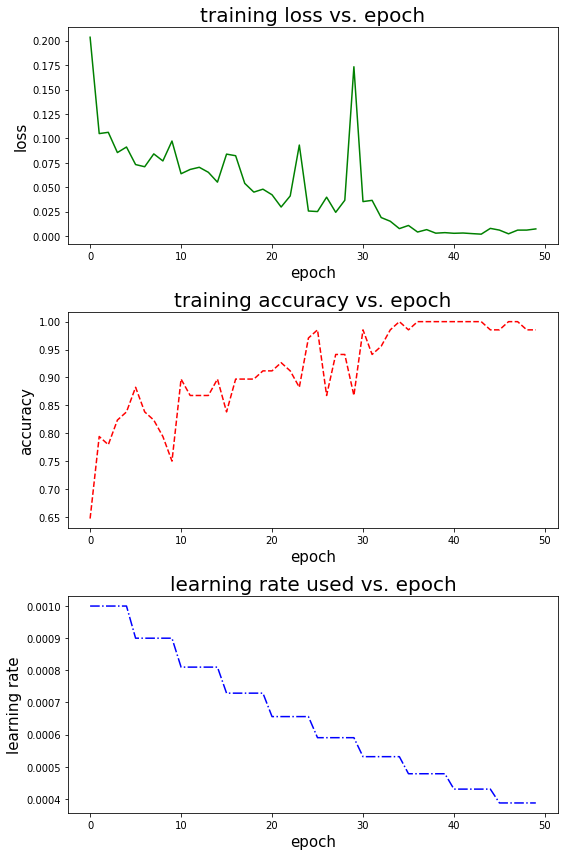

In [90]:
fig = plt.figure(figsize=(8, 12))

plt.subplot(311)
plt.plot(train_epoch, train_loss,'g-')
plt.title('training loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(312)
plt.plot(train_epoch, train_acc,'r--')
plt.title('training accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()
plt.subplot(313)
plt.plot(train_epoch, learning_rate_used,'b-.')
plt.title('learning rate used vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('learning rate', fontsize = 15)
plt.tight_layout()
fig.savefig('all_figures.png')

In [91]:
val_epoch = []
val_acc = []
val_loss = []
for i in history['val']:
    val_epoch.append(i['epoch'])
    val_loss.append(i['epoch_loss'])
    val_acc.append(i['epoch_accuracy'])
    

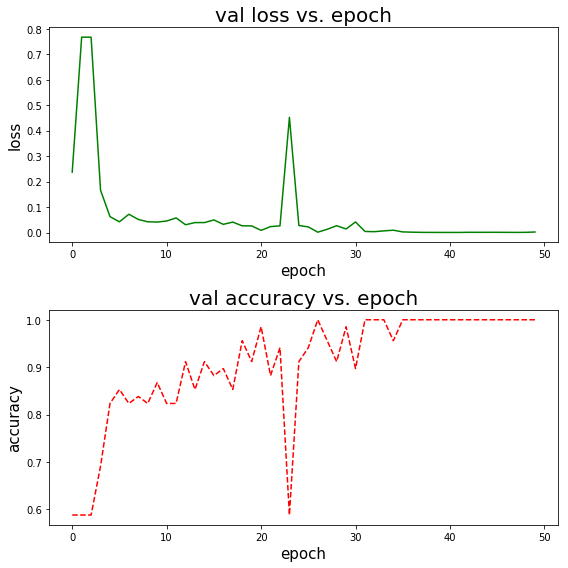

In [96]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.plot(val_epoch, val_loss,'g-')
plt.title('val loss vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.tight_layout()
plt.subplot(212)
plt.plot(val_epoch, val_acc,'r--')
plt.title('val accuracy vs. epoch',fontsize=20)
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.tight_layout()

fig.savefig('all_figures_val_gnet.png')